## _*LiH dissociation curve using NumPyMinimumEigensolver*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy and dipole moments of a Lithium Hydride (LiH) molecule over a range of inter-atomic distances.

This notebook has been written to use the PYSCF chemistry driver. 

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [2]:
# Note: In order to allow this to run reasonably quickly it takes advantage
#       of the ability to freeze core orbitals and remove unoccupied virtual
#       orbitals to reduce the size of the problem.

# tested molecular, LiH
molecule = 'Li .0 .0 -{0}; H .0 .0 {0}'

In [3]:
# choose 'NumPyMinimumEigensolver' or 'VQE' for experiments
algorithm = 'NumPyMinimumEigensolver'

In [4]:
# configure distance between two atoms
pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
distances   = np.empty(len(pts))
hf_energies = np.empty(len(pts))
energies    = np.empty(len(pts))
dipoles     = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True) 
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True,
                            freeze_core=True, orbital_reduction=[-3, -2])
    qubit_op, aux_ops = operator.run(qmolecule)
    if algorithm == 'NumPyMinimumEigensolver':
        result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    else:
        optimizer = COBYLA(maxiter=20000)
        var_form = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=10)
        algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
        result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    
    result = operator.process_algorithm_result(result)
    distances[i] = d
    hf_energies[i] = result.hartree_fock_energy
    energies[i] = result.energy
    dipoles[i]  = result.total_dipole_moment / 0.393430307
print(' --- complete')

print('Distances: ', distances)
print('HF Energies:', hf_energies)
print('Energies:', energies)
print('Dipole moments:', dipoles)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
HF Energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.68437642 -7.6612016  -7.64145387 -7.62497563]
Energies: [-7.31334583 -7.50092209 -7.63097825 -7.72081241 -7.7822424  -7.82359928
 -7.85069838 -7.86756329 -7.87700149 -7.88101572 -7.88107204 -7.87826817
 -7.87344029 -7.86723396 -7.86015321 -7.84104271 -7.82307664 -7.8086124
 -7.79836343 -7.79175325 -7.78771697 -7.78531972 -7.78391847]
Dipole moments: [5.3479565  5.05436846 4.89154649 4.80824206 4.76423166 4.73775921
 4.71893511 4.70394304 4.69125691 4.67959192 4.66694467 4.65022445
 4.62517401 4.5864183  4.52758314 4.24518851 3.69244462 2.8795465
 1.99991673 1.27228084 0.76878114 0.451

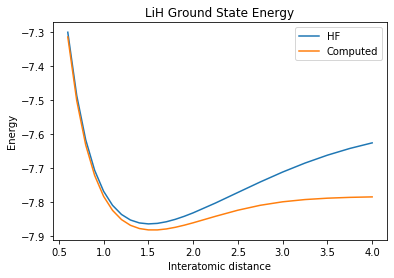

In [5]:
pylab.plot(distances, hf_energies, label='HF')
pylab.plot(distances, energies, label='Computed')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

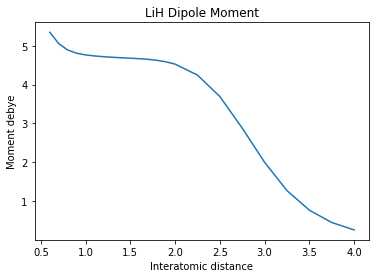

In [6]:
pylab.plot(distances, dipoles)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment debye')
pylab.title('LiH Dipole Moment');